# Process Lidar

This run was done with 8 m6a.4xlarge EC2 Instance.  Got them on that spot pricing dude!

In [1]:
import geopandas as gpd
import pandas as pd
#import geoplot as gplt
import laspy
import shapely
import os
from datetime import datetime, timedelta
import numpy as np
from itertools import product
import math
import pyproj
import re
import pyspark
import warnings
from collections import defaultdict

In [2]:
def lp(v, suppressOut=False):
    if not suppressOut:
        print(f"[{datetime.now()}] {v}")

lp("Starting...")

[2025-03-30 01:05:26.214255] Starting...


In [3]:
resolution = 100  #grid resolution in meters
#partitions = 40
executorRam = "50g"
outPath = f"{os.curdir}{os.sep}output{os.sep}"
lazPath = f"{os.path.realpath(os.curdir)}{os.sep}datasets{os.sep}laz{os.sep}"
lp(f"lazPath:  {lazPath}")
assert os.path.exists(lazPath), f"{lazPath} does not exists PANIC!"
outputFileName = f"{outPath}AggregateLidarData_{resolution}m.parquet"
captureHoods = []


[2025-03-30 01:05:26.222317] lazPath:  /home/ec2-user/notebooks/NewOrleansElevation/datasets/laz/


In [4]:
if not os.path.exists(outPath):
    lp(f"Creating output path {outPath}")
    os.makedirs(outPath)

In [5]:
lp("Creating spark context")
conf = pyspark.SparkConf().setAppName(outputFileName).set("spark.executor.memory", executorRam).setMaster("spark://ip-10-0-4-160.ec2.internal:7077")
sc = pyspark.SparkContext(conf=conf)

[2025-03-30 01:05:26.235850] Creating spark context


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/30 01:05:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
dataPath = f"{os.curdir}{os.sep}datasets{os.sep}"
fullDataPath = os.path.realpath(dataPath) + os.sep
lp(f"Path:  {dataPath}\t\tFullPath:{fullDataPath}")

[2025-03-30 01:05:30.173972] Path:  ./datasets/		FullPath:/home/ec2-user/notebooks/NewOrleansElevation/datasets/


In [7]:
testLasFileName = os.listdir(f"{dataPath}laz")[5]
lp(f"Opening {testLasFileName} to get crs and more")
with laspy.open(f"{dataPath}laz{os.sep}{testLasFileName}", 'r') as f: 
    testLas = f.read()

[2025-03-30 01:05:30.181059] Opening USGS_LPC_LA_2021GreaterNewOrleans_C22_w0801n3325.laz to get crs and more


In [8]:
neighborhoodDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson").to_crs(testLas.vlrs[0].parse_crs())

In [9]:
sorted(neighborhoodDf['gnocdc_lab'].unique())

['ALGIERS POINT',
 'AUDUBON',
 'B. W. COOPER',
 'BAYOU ST. JOHN',
 'BEHRMAN',
 'BLACK PEARL',
 'BROADMOOR',
 'BYWATER',
 'CENTRAL BUSINESS DISTRICT',
 'CENTRAL CITY',
 'CITY PARK',
 'DESIRE AREA',
 'DILLARD',
 'DIXON',
 'EAST CARROLLTON',
 'EAST RIVERSIDE',
 'FAIRGROUNDS',
 'FILMORE',
 'FISCHER DEV',
 'FLORIDA AREA',
 'FLORIDA DEV',
 'FRENCH QUARTER',
 'FRERET',
 'GARDEN DISTRICT',
 'GENTILLY TERRACE',
 'GENTILLY WOODS',
 'GERT TOWN',
 'HOLLYGROVE',
 'HOLY CROSS',
 'IBERVILLE',
 'IRISH CHANNEL',
 'LAKE CATHERINE',
 'LAKE TERRACE & OAKS',
 'LAKESHORE - LAKE VISTA',
 'LAKEVIEW',
 'LAKEWOOD',
 'LEONIDAS',
 'LITTLE WOODS',
 'LOWER GARDEN DISTRICT',
 'LOWER NINTH WARD',
 'MARIGNY',
 'MARLYVILLE - FONTAINEBLEAU',
 'MID-CITY',
 'MILAN',
 'MILNEBURG',
 'McDONOGH',
 'NAVARRE',
 'NEW AURORA - ENGLISH TURN',
 'OLD AURORA',
 'PINES VILLAGE',
 'PLUM ORCHARD',
 'PONTCHARTRAIN PARK',
 'READ BLVD EAST',
 'READ BLVD WEST',
 'SEVENTH WARD',
 'ST.  ANTHONY',
 'ST. BERNARD AREA',
 'ST. CLAUDE',
 'ST. ROCH

In [10]:
if len(captureHoods) > 0:
    captureHoodsMask = neighborhoodDf['gnocdc_lab'].isin(captureHoods)
else:
    captureHoodsMask = np.repeat(True, neighborhoodDf.shape[0])

<Axes: >

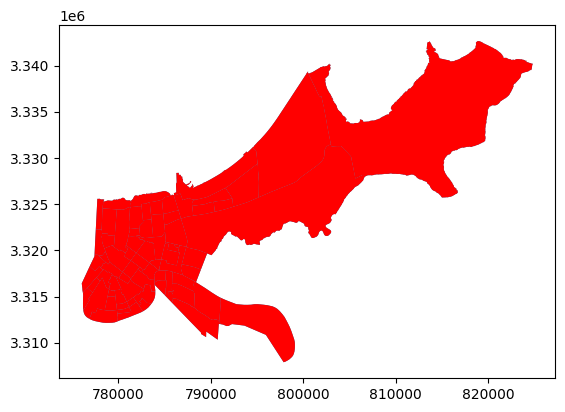

In [11]:
ax = neighborhoodDf.plot()
neighborhoodDf[captureHoodsMask].plot(ax=ax, color='red')

In [12]:
bounds = [int(b) for b in neighborhoodDf[captureHoodsMask].total_bounds]

In [13]:
xPixels = (bounds[2] - bounds[0]) / resolution
yPixels = (bounds[3] - bounds[1]) / resolution
lp(f"Resolution will be {xPixels} x {yPixels}  Runtime based on {xPixels*yPixels}")

[2025-03-30 01:05:31.671062] Resolution will be 488.07 x 347.58  Runtime based on 169643.3706


In [14]:
boxes = [shapely.box(x,y,x+resolution,y+resolution) for x, y in product(range(bounds[0], bounds[2], resolution), range(bounds[1], bounds[3], resolution))]
boxesDf = gpd.GeoDataFrame(geometry=boxes).set_crs(neighborhoodDf.crs)
boxesDf = boxesDf[boxesDf.intersects(neighborhoodDf[captureHoodsMask].union_all())].copy()
boxesDf['AltitudeTotal'] = np.nan
boxesDf['WaterTotal'] = np.nan
boxesDf['Int'] = np.nan
boxesDf['Total'] = np.nan
boxesDf['RunTime'] = datetime.now()-datetime.now()


In [15]:
lp("Broadcasting boxes")
boxesBroadcast = sc.broadcast( np.array(list(boxesDf['geometry'].bounds.itertuples(name=None) )))

[2025-03-30 01:06:17.961113] Broadcasting boxes


In [16]:
boxesBroadcast.value[0]

array([7.600000e+01, 7.760390e+05, 3.315488e+06, 7.761390e+05,
       3.315588e+06])

In [17]:
len(boxesBroadcast.value)

55104

<Axes: >

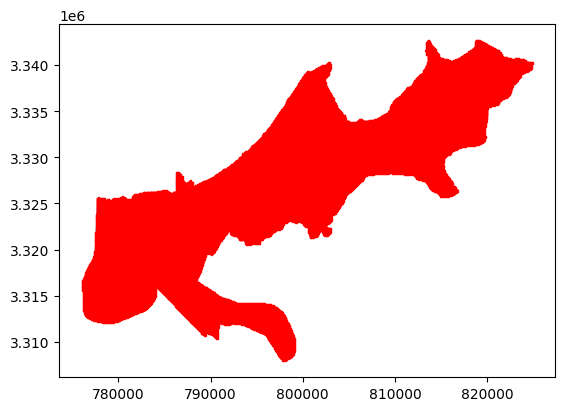

In [18]:
ax = neighborhoodDf.plot()
boxesDf.plot(edgecolor='red', color=None, ax=ax)

In [19]:
tileIndex = gpd.read_file(f"{dataPath}USGS_LA_2021GNO_1_C22_TileIndex{os.sep}USGS_LA_2021GNO_1_C22_TileIndex.shp").to_crs(neighborhoodDf.crs)
tileIndex.index = tileIndex['Name'].map(lambda f: f"{fullDataPath}laz{os.sep}USGS_LPC_LA_2021GreaterNewOrleans_C22_{f}.laz")
tileIndexBroadcast = sc.broadcast(tileIndex['geometry'].map(lambda g: g.bounds).to_dict())
tileIndexBroadcast.value[tileIndex.index[0]]
lp(f"tileIndexBroadcast length:  {len(tileIndexBroadcast.value)}")

[2025-03-30 01:06:25.684976] tileIndexBroadcast length:  7589


In [20]:
def processLas(lasFileName, suppressOut=True):
    startLazTime = datetime.now()

    lp(f"Processing {lasFileName}...",suppressOut)
    
    with laspy.open(lasFileName, 'r') as f:
        las = f.read()

    

    outDict = {}

    lazBox = shapely.box(*tileIndexBroadcast.value[lasFileName])
    boxMask = gpd.GeoSeries(map(lambda b: shapely.box(*b[1:]), boxesBroadcast.value)).intersects(lazBox)
    
    for inputTup in boxesBroadcast.value[boxMask]:
        startTime = datetime.now()
        
        altTotal = 0
        waterTotal = 0
        pointTotal = 0
        intenseTotal = 0
    
    

        BoxIdx = inputTup[0]
        boxBounds = inputTup[1:]
            
        transBoxBounds = (  int((boxBounds[0] - las.header.offsets[0]) / las.header.scales[0]),\
                            int((boxBounds[1] - las.header.offsets[1]) / las.header.scales[1]),\
                            int((boxBounds[2] - las.header.offsets[0]) / las.header.scales[0]),\
                            int((boxBounds[3] - las.header.offsets[1]) / las.header.scales[1]),)

        
        lp(f"LAZ Bounds         = ({las.header.mins[0]},{las.header.mins[1]},{las.header.maxs[0]},{las.header.maxs[1]})",suppressOut)
        lp(f"LAZ Unscale Bounds = ({las.X.min()},{las.Y.min()},{las.X.max()},{las.y.max()})",suppressOut)
        lp(f"newBox:  {transBoxBounds}", suppressOut)
        
        X = las.X
        Y = las.Y
        Z = las.Z
        cls = las.classification
        intense = las.intensity

                
        groundMask = np.isin(cls, [2,9])
        inBoundsMaskX = np.logical_and(X >= (transBoxBounds[0]), (X <= (transBoxBounds[2])))
        lp(f"InBoundsX:  {np.count_nonzero(inBoundsMaskX)}", suppressOut)
        inBoundsMaskY = np.logical_and(Y >= (transBoxBounds[1]), (Y <= (transBoxBounds[3])))
        lp(f"InBoundsY:  {np.count_nonzero(inBoundsMaskY)}", suppressOut)
        inBoundsMask = np.logical_and(inBoundsMaskX,inBoundsMaskY)
        lp(f"InBounds:  {np.count_nonzero(inBoundsMask)}", suppressOut)
        goodPointMask = np.logical_and( groundMask, inBoundsMask)
        
        lp(f"Good points / Total {np.count_nonzero(goodPointMask)}/{goodPointMask.shape[0]}", suppressOut)
 
        altTotal += int(Z[goodPointMask].sum())
        waterTotal += np.count_nonzero(cls[goodPointMask] == 9)
        intenseTotal += int(intense[goodPointMask].sum())
        pointTotal += np.count_nonzero(goodPointMask)

        outDict[BoxIdx] = (altTotal, waterTotal, intenseTotal, pointTotal, datetime.now() - startTime)
        

    lp(f"LAZ:  {lasFileName} processed in {datetime.now()-startLazTime}")

    return (lasFileName, outDict)


In [21]:
def seqOp(x1, x2):
    outDict = defaultdict(lambda: (0,0,0,0, timedelta(0)), x1)
    x2Dict = x2[1]
    
    for key, value in x2Dict.items():
        outDict[key] = tuple((outDict[key][i] + value[i] for i in range(5) ))

    return dict(outDict)

def comboOp(x1,x2):
    outDict = {}
    x1Dict =defaultdict(lambda: (0,0,0,0, timedelta(0)), x1)
    x2Dict =defaultdict(lambda: (0,0,0,0, timedelta(0)), x2)
    for boxTup in boxesBroadcast.value:
        idx = boxTup[0]
        outDict[idx] = tuple((x1Dict[idx][i] + x2Dict[idx][i] for i in range(5)))

    return outDict


#testing
if False:
    
    test1 = processLas(os.path.realpath("datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0776n3315.laz"), suppressOut=False)
    test2 = processLas(os.path.realpath("datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0780n3324.laz"), suppressOut=False)
    testSeq1 = seqOp({}, test1)   
    testSeq2 = seqOp(testSeq1, test2)
    print(testSeq2)
                     
    out = comboOp(comboOp(testSeq1, testSeq2), testSeq1)

    print(out)

In [22]:
lazFiles = [lazPath + p for p in os.listdir(lazPath) if p[-4:]=='.laz']

In [23]:
partitions = round(len(lazFiles) / 3)
lp(f"Partitions:  {partitions}")
boxesRdd = sc.parallelize(lazFiles,partitions)

[2025-03-30 01:06:25.724396] Partitions:  206


In [24]:
boxesProcessedRdd = boxesRdd.map(processLas)

In [25]:
lp(f"{boxesDf.shape[0]} boxes total")

[2025-03-30 01:06:26.015600] 55104 boxes total


In [26]:
sparkTime = datetime.now()
output = boxesProcessedRdd.aggregate({}, seqOp, comboOp)
lp(f"Spark completed in {datetime.now() - sparkTime}")

[2025-03-30 01:18:08.269825] Spark completed in 0:11:42.248845


In [27]:
sc.stop()

In [28]:
for key,value in output.items():

    boxesDf.loc[key, 'AltitudeTotal'] = value[0]
    boxesDf.loc[key, 'WaterTotal'] = value[1]
    boxesDf.loc[key, 'Int'] = value[2]
    boxesDf.loc[key, 'Total'] = value[3]
    boxesDf.loc[key, 'RunTime'] = value[4]

In [29]:
boxesDf.head()

,geometry,AltitudeTotal,WaterTotal,Int,Total,RunTime
76,"POLYGON ((776139 3315488, 776139 3315588, 7760...",0.0,0.0,0.0,0.0,0 days 00:00:00.228102
77,"POLYGON ((776139 3315588, 776139 3315688, 7760...",0.0,0.0,0.0,0.0,0 days 00:00:00.200766
78,"POLYGON ((776139 3315688, 776139 3315788, 7760...",0.0,0.0,0.0,0.0,0 days 00:00:00.198523
79,"POLYGON ((776139 3315788, 776139 3315888, 7760...",0.0,0.0,0.0,0.0,0 days 00:00:00.181250
80,"POLYGON ((776139 3315888, 776139 3315988, 7760...",0.0,0.0,0.0,0.0,0 days 00:00:00.190977


In [30]:
boxesDf.to_parquet(outputFileName)

In [31]:
with open(f"{outPath}FinishTime_{resolution}m.txt", 'w') as f:
    f.write(f"Finished shape {boxesDf.shape}  stop time {datetime.now()}")

In [32]:
lp(f"Mean runtime:  {boxesDf['RunTime'].mean()}")
lp(f"Max runtime:  {boxesDf['RunTime'].max()}")
lp(f"Total runtime:  {boxesDf['RunTime'].sum()}")
lp(f"Totals Min/Mean/Max\t\t{boxesDf['Total'].min()} / {boxesDf['Total'].mean()} / {boxesDf['Total'].max()}")

[2025-03-30 01:18:50.852421] Mean runtime:  0 days 00:00:01.028838
[2025-03-30 01:18:50.853908] Max runtime:  0 days 00:00:07.719371
[2025-03-30 01:18:50.854189] Total runtime:  0 days 15:44:53.110834
[2025-03-30 01:18:50.854607] Totals Min/Mean/Max		0.0 / 21259.541721109177 / 122158.0


<Axes: >

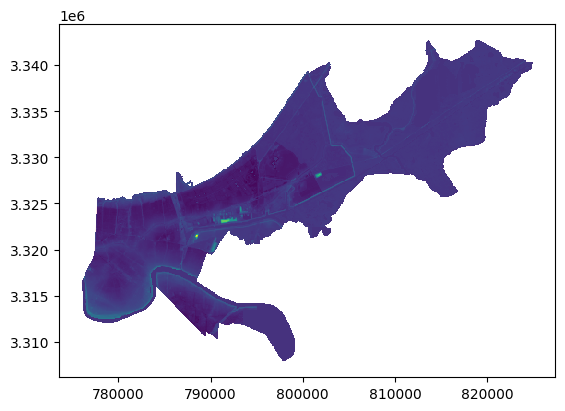

In [33]:
boxesDf['AltCalc'] = boxesDf['AltitudeTotal'] / boxesDf['Total']
boxesDf.loc[pd.isna(boxesDf['AltCalc']),'AltCalc'] = 0
ax = neighborhoodDf.plot(color='pink')
boxesDf.plot(column='AltCalc',ax=ax)

<Axes: >

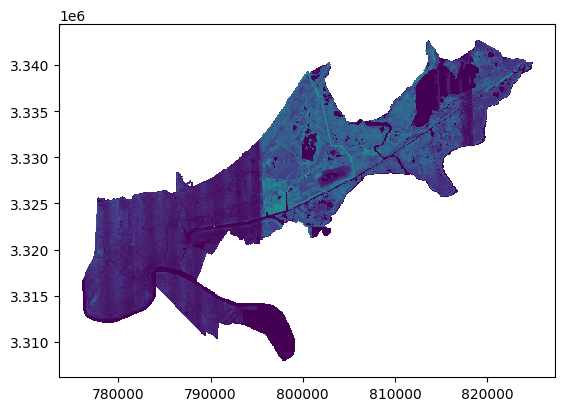

In [34]:
boxesDf['IntCalc'] = boxesDf['Int'] / boxesDf['Total']
boxesDf.loc[pd.isna(boxesDf['IntCalc']),'IntCalc'] = 0
ax = neighborhoodDf.plot(color='pink')
boxesDf.plot(column='IntCalc',ax=ax)

In [35]:
lp("Done!")

[2025-03-30 01:19:05.466042] Done!


In [36]:
!aws s3 cp $outputFileName s3://requesterpays.garyscorner.net/datasets/NewOrleansElevation/

upload: output/AggregateLidarData_100m.parquet to s3://requesterpays.garyscorner.net/datasets/NewOrleansElevation/AggregateLidarData_100m.parquet
